In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
from src.settings import *
from pathlib import Path
from src.tools.osmnx_utils import get_place_dir_name
from keplergl import KeplerGl
import contextily as ctx
import matplotlib.pyplot as plt
import plotly.express as px
import pickle as pkl
from tqdm.auto import tqdm
import json

tqdm.pandas()

In [23]:
place_name = "Wrocław,Poland"
place_dir_name = get_place_dir_name(place_name)
resolution = 8
buffered = True
hexagons = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"hex_{resolution}{'_buffered' if buffered else ''}.geojson"), driver="GeoJSON")\
    .set_index("h3_id")\
    .drop(columns=["coordinates", "parent", "children", "resolution"])
hexagons.head(5)

,geometry
h3_id,
881e20425dfffff,"POLYGON ((16.92238 51.19185, 16.91996 51.18757..."
881e204053fffff,"POLYGON ((16.96634 51.13517, 16.96392 51.13089..."
881e204701fffff,"POLYGON ((17.09422 51.14149, 17.09180 51.13722..."
881e20470bfffff,"POLYGON ((17.10415 51.14683, 17.10173 51.14255..."
881e2051b7fffff,"POLYGON ((16.85026 51.16187, 16.84786 51.15759..."


In [24]:
otodom = gpd.read_file(RAW_DATA_DIR.joinpath("OtodomPrices.geojson"))
otodom.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13726 entries, 0 to 13725
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           13726 non-null  int64   
 1   title        13726 non-null  object  
 2   description  13726 non-null  object  
 3   address      13726 non-null  object  
 4   area         13726 non-null  float64 
 5   price        13726 non-null  float64 
 6   price_per_m  13726 non-null  float64 
 7   build_year   13726 non-null  object  
 8   geometry     13726 non-null  geometry
dtypes: float64(3), geometry(1), int64(1), object(4)
memory usage: 965.2+ KB


In [25]:
gdf = gpd.sjoin(hexagons, otodom, op="intersects", how="inner").drop(columns=["index_right"]).rename(columns={"id": "count"})
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 13685 entries, 881e204053fffff to 881e204295fffff
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   geometry     13685 non-null  geometry
 1   count        13685 non-null  int64   
 2   title        13685 non-null  object  
 3   description  13685 non-null  object  
 4   address      13685 non-null  object  
 5   area         13685 non-null  float64 
 6   price        13685 non-null  float64 
 7   price_per_m  13685 non-null  float64 
 8   build_year   13685 non-null  object  
dtypes: float64(3), geometry(1), int64(1), object(4)
memory usage: 1.0+ MB


In [26]:
gdf_grouped = gdf.groupby(by="h3_id").agg(func={"count": "count", "price": "mean", "price_per_m": "mean", "area": "mean"}).join(hexagons, how="right").fillna(0)
gdf_grouped = gpd.GeoDataFrame(gdf_grouped).set_crs(epsg=4326)
gdf_grouped

,count,price,price_per_m,area,geometry
h3_id,,,,,
881e20425dfffff,0.0,0.000000,0.000000,0.000000,"POLYGON ((16.92238 51.19185, 16.91996 51.18757..."
881e204053fffff,17.0,422852.941176,7993.941176,54.368235,"POLYGON ((16.96634 51.13517, 16.96392 51.13089..."
881e204701fffff,6.0,449366.666667,8331.666667,55.103333,"POLYGON ((17.09422 51.14149, 17.09180 51.13722..."
881e20470bfffff,16.0,418646.875000,7460.812500,56.870625,"POLYGON ((17.10415 51.14683, 17.10173 51.14255..."
881e2051b7fffff,2.0,744500.000000,7643.500000,97.500000,"POLYGON ((16.85026 51.16187, 16.84786 51.15759..."
...,...,...,...,...,...
881e204231fffff,12.0,396207.583333,7387.083333,53.976667,"POLYGON ((16.93578 51.15442, 16.93337 51.15014..."
881e204629fffff,0.0,0.000000,0.000000,0.000000,"POLYGON ((17.14391 51.16816, 17.14148 51.16389..."
881e2042adfffff,13.0,542764.076923,6891.538462,75.654615,"POLYGON ((16.97626 51.14051, 16.97384 51.13623..."


In [27]:
data_columns = ["price", "price_per_m", "area"]

# Otodom EDA

In [28]:
len(otodom)

13726

In [29]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=len(data_columns), subplot_titles=data_columns)

for index, data_column in enumerate(data_columns):
    fig.add_trace(go.Violin(y=otodom[data_column], box_visible=True, points="outliers"), row=1, col=index+1)
fig.update_layout(showlegend=False)
fig.show()

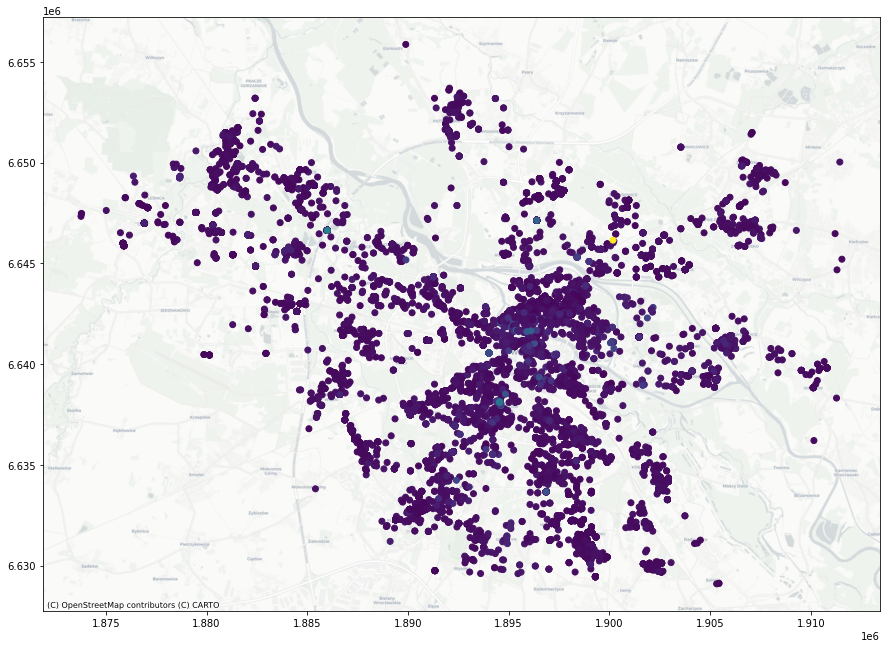

In [30]:
FIGSIZE = (15, 15)
MAP_SOURCE = ctx.providers.CartoDB.Positron

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
# ax.set_aspect('equal')
otodom.to_crs(epsg=3857).plot(ax=ax, column="price")
ctx.add_basemap(ax, source=MAP_SOURCE)

In [33]:
kepler_config_price_per_m_path = KEPLER_DIR.joinpath("kepler_config_price_per_m.json")
if kepler_config_price_per_m_path.exists():
    with open(kepler_config_price_per_m_path, "r") as f:
        config = json.load(f)
else:
    config = {}
    
m = KeplerGl(config=config)
m.add_data(gdf_grouped.copy(), name="hexagons")
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['hexagons'], 'id': '0rzcjl69…

In [34]:
with open(kepler_config_price_per_m_path, "w") as f:
    json.dump(m.config, f, indent=2)